# Laboratory values vs outcome

Get the first laboratory measurements for patients admitted to the ICU. Plot the distribution of measurements for survival and non-survival groups.

In [1]:
# Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot') 

# Load in merged GOSSIS data

In [2]:
df = pd.read_csv('gosiss-data.csv',header=0,sep=",")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (1,5,6,9,10,16,18,19,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load in the header and the data type for each column

In [3]:
hdr = pd.read_csv('hdr/header.csv',header=None,sep=',')[0].values

# load yaml definitions
with open("hdr/variable-definitions.yaml", 'r') as stream:
    try:
        varlist = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# convert to dataframe
df_var = pd.DataFrame.from_dict(varlist, orient='index')
df_var['varname'] = df_var.index

# specify the order of the categories - data is output in this order
category_order = {'identifier': 1,
                  'demographic': 2,
                  'APACHE covariate': 3,
                  'vitals': 4,
                  'labs': 5,
                  'labs blood gas': 6,
                  'APACHE prediction': 10}
df_var['category_order'] = df_var['category'].map(category_order)

# sort df by the category, then by the variable name
df_var.sort_values(['category_order','varname'],inplace=True)

In [4]:
df_var['category'].value_counts()

vitals               64
labs                 60
demographic          27
APACHE covariate     25
labs blood gas       16
identifier            4
APACHE prediction     4
Name: category, dtype: int64

In [5]:
df_var['dataType'].value_counts()

numeric    167
string      14
binary      11
integer      8
Name: dataType, dtype: int64

# Comparisons

For comparisons, we are interested assessing each variable across the databases.

For numeric/integer variables:

* Compare the mean, median, standard deviation, 5th and 95th percentiles
* Plot the distribution using histograms

For string/binary (categorical) variables:

* Compare the categories to see if they overlap
* Compare the frequency of each category (cross-tab)

## Compare readmissions

In [6]:
tbl = pd.crosstab(df['data_source'], df['readmission_status'], margins = True)
display(HTML(tbl.to_html().replace('NaN', '')))

readmission_status,0.0,1.0,All
data_source,,,
anzics,289221,14591,303812
eicu,161020,10157,171177
mimic,48580,80,48660
orchestra,59693,0,59693
All,558514,24828,583342


## Compare APACHE-III score in eicu and anzics patients

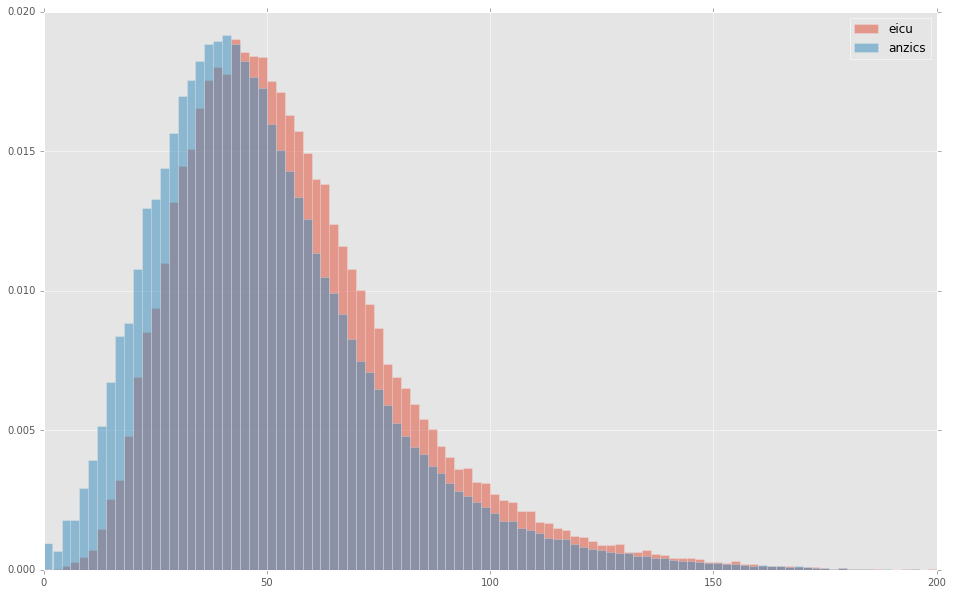

In [7]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
#plt.hist(df_all.loc[df_all['db']=='mimic','apsiii'].values, bins,
#         normed=True, alpha=0.5, label='mimic')
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.legend(loc='upper right')
plt.show()

As we can see the distributions are very similar, though ANZICS seems to have lower acuity.

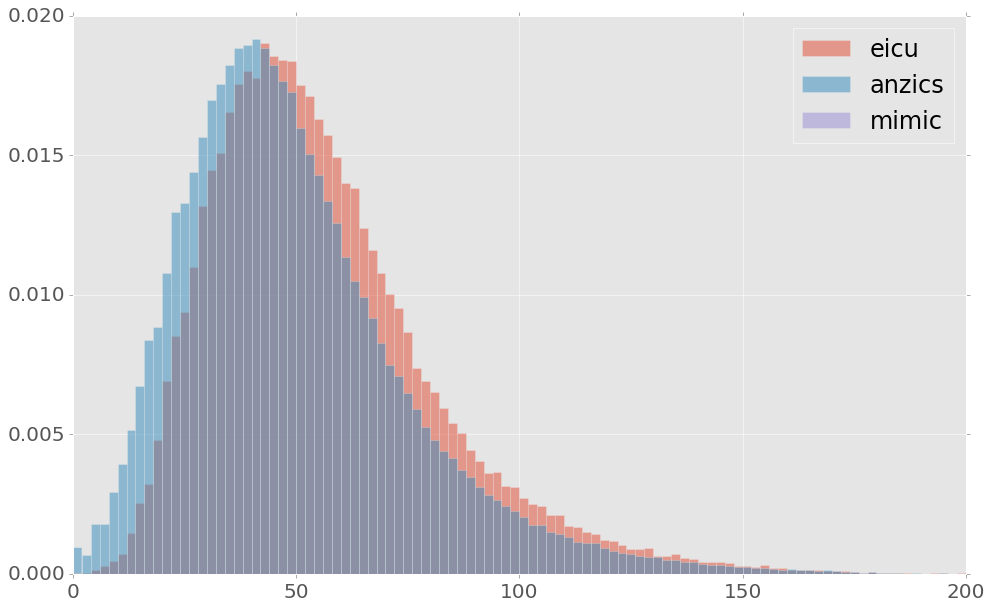

In [8]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
plt.rcParams.update({'font.size': 20})
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.hist(df.loc[df['data_source']=='mimic','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='mimic')
plt.legend(loc='upper right')
plt.show()

Note that we don't have any data for MIMIC for the APACHE-III score.